<a href="https://colab.research.google.com/github/nanpolend/machine-learning/blob/master/%E5%8F%B0%E7%81%A3%E8%82%A1%E5%B8%82tsmc%E5%91%A8%E6%9C%9F%E5%BE%AA%E7%92%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20729 (\N{CJK UNIFIED IDEOGRAPH-50F9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21488 (\N{CJK UNIFIED IDEOGRAPH-53F0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31309 (\N{CJK UNIFIED IDEOGRAPH-7A4D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 38651 (\N{CJK UNIFIED IDEOGRAPH-96FB}) missing from font(s) DejaVu Sans.
  fig.canvas

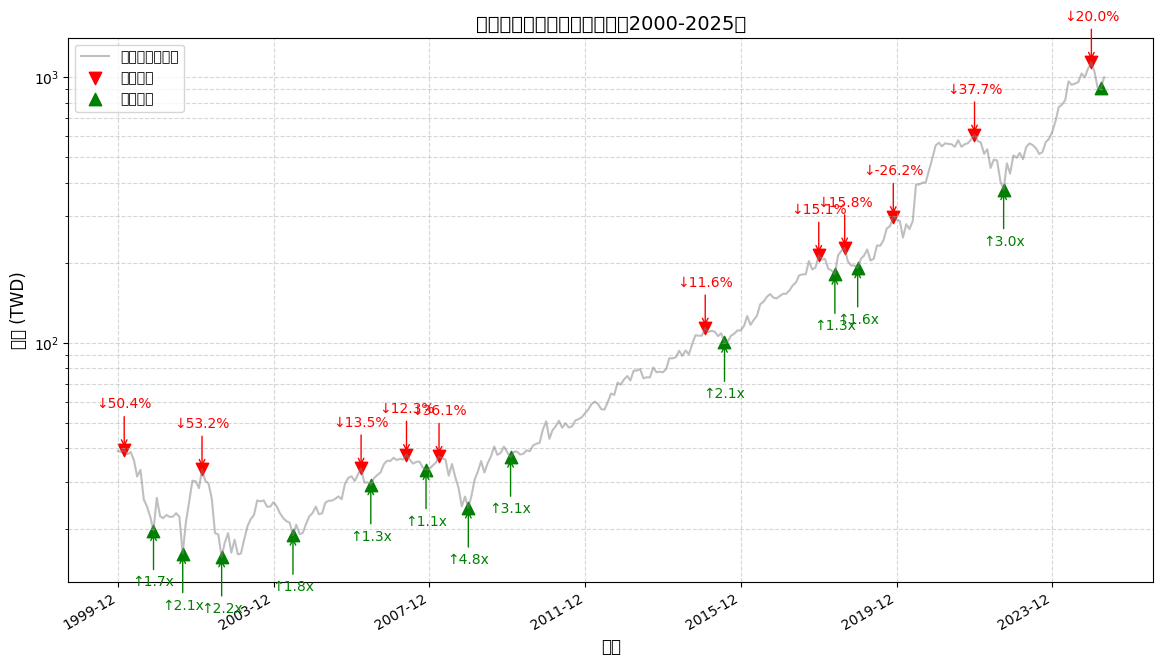

,高點時間,低點時間,高點價格,低點價格,跌幅(%)
0,2000-03,2000-12,40,20,50.4%
1,2002-03,2002-09,33,16,53.2%
2,2006-04,2006-07,34,29,13.5%
3,2007-06,2007-12,38,33,12.3%
4,2008-04,2009-01,37,24,36.1%
5,2015-02,2015-08,113,100,11.6%
6,2018-01,2018-06,213,181,15.1%
7,2018-09,2019-01,227,191,15.8%
8,2019-12,2022-10,298,377,-26.2%
9,2022-01,2022-10,604,377,37.7%


,低點時間,高點時間,低點價格,高點價格,漲幅(倍)
0,2000-12,2002-03,20,33,1.7x
1,2001-09,2002-03,16,33,2.1x
2,2002-09,2006-04,16,34,2.2x
3,2004-07,2006-04,19,34,1.8x
4,2006-07,2007-06,29,38,1.3x
5,2007-12,2008-04,33,37,1.1x
6,2009-01,2015-02,24,113,4.8x
7,2010-02,2015-02,37,113,3.1x
8,2015-08,2018-01,100,213,2.1x
9,2018-06,2018-09,181,227,1.3x


In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display

# 設定中文字體與符號顯示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # Mac 使用，Windows 可改為 'Microsoft JhengHei'
plt.rcParams['axes.unicode_minus'] = False

# --------------------
# 1. 從 Yahoo Finance 抓取台積電月線數據
# --------------------
def fetch_tsmc_monthly_data():
    """抓取台積電（股票代號 2330.TW）歷史月線收盤價"""
    tsmc = yf.Ticker("2330.TW")
    df = tsmc.history(period="max", interval="1mo")
    df = df[['Close']].reset_index()
    df.columns = ['timestamp', 'price']
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df.dropna()

# --------------------
# 2. 識別局部高點與低點
# --------------------
def identify_extrema(df, window=6):
    """使用滑動窗口識別局部高點和低點"""
    # 找局部高點
    high_idx = argrelextrema(df['price'].values, np.greater, order=window)[0]
    highs = df.iloc[high_idx]
    # 找局部低點
    low_idx = argrelextrema(df['price'].values, np.less, order=window)[0]
    lows = df.iloc[low_idx]
    return highs, lows

# --------------------
# 3. 計算漲跌週期與幅度
# --------------------
def calculate_cycles(highs, lows):
    """計算跌勢週期（高點→低點）和漲勢週期（低點→高點）"""
    # 跌勢週期
    bear_cycles = []
    for i in range(len(highs)):
        subsequent_lows = lows[lows['timestamp'] > highs.iloc[i]['timestamp']]
        if not subsequent_lows.empty:
            low = subsequent_lows.iloc[0]
            drawdown = (highs.iloc[i]['price'] - low['price']) / highs.iloc[i]['price'] * 100
            bear_cycles.append({
                '高點時間': highs.iloc[i]['timestamp'].strftime('%Y-%m'),
                '低點時間': low['timestamp'].strftime('%Y-%m'),
                '高點價格': round(highs.iloc[i]['price'], 2),
                '低點價格': round(low['price'], 2),
                '跌幅(%)': round(drawdown, 1)
            })

    # 漲勢週期
    bull_cycles = []
    for i in range(len(lows)):
        subsequent_highs = highs[highs['timestamp'] > lows.iloc[i]['timestamp']]
        if not subsequent_highs.empty:
            high = subsequent_highs.iloc[0]
            multiplier = high['price'] / lows.iloc[i]['price']
            bull_cycles.append({
                '低點時間': lows.iloc[i]['timestamp'].strftime('%Y-%m'),
                '高點時間': high['timestamp'].strftime('%Y-%m'),
                '低點價格': round(lows.iloc[i]['price'], 2),
                '高點價格': round(high['price'], 2),
                '漲幅(倍)': round(multiplier, 1)
            })

    return pd.DataFrame(bear_cycles), pd.DataFrame(bull_cycles)

# --------------------
# 4. 繪製價格走勢圖與週期標註
# --------------------
def plot_tsmc_cycles(df, highs, lows, bear_df, bull_df):
    """繪製台積電月線價格與漲跌週期標註"""
    plt.figure(figsize=(14, 8))
    plt.plot(df['timestamp'], df['price'], label='台積電月收盤價', color='gray', alpha=0.5)

    # 標註高點與低點
    plt.scatter(highs['timestamp'], highs['price'], color='red', marker='v', s=80, label='局部高點')
    plt.scatter(lows['timestamp'], lows['price'], color='green', marker='^', s=80, label='局部低點')

    # 標註跌勢週期
    for _, row in bear_df.iterrows():
        plt.annotate(
            f"↓{row['跌幅(%)']}%",
            xy=(pd.to_datetime(row['高點時間']), row['高點價格']),
            xytext=(0, 30),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='red'),
            color='red',
            ha='center'
        )

    # 標註漲勢週期
    for _, row in bull_df.iterrows():
        plt.annotate(
            f"↑{row['漲幅(倍)']}x",
            xy=(pd.to_datetime(row['低點時間']), row['低點價格']),
            xytext=(0, -40),
            textcoords='offset points',
            arrowprops=dict(arrowstyle="->", color='green'),
            color='green',
            ha='center'
        )

    # 設置圖表格式
    start_year = df['timestamp'].min().year
    end_year = df['timestamp'].max().year
    plt.title(f'台積電月線價格與漲跌週期（{start_year}-{end_year}）', fontsize=14)
    plt.xlabel('時間', fontsize=12)
    plt.ylabel('價格 (TWD)', fontsize=12)
    plt.yscale('log')
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gcf().autofmt_xdate()
    plt.show()

# --------------------
# 5. 輸出統計表格（高亮最大漲跌幅）
# --------------------
def highlight_max(s, props=''):
    """高亮顯示最大值"""
    return np.where(s == s.max(), props, '')

def display_statistics(bear_df, bull_df):
    """顯示互動式統計表格"""
    # 跌勢週期表格
    display(bear_df.style
            .format({'高點價格': '{:,.0f}', '低點價格': '{:,.0f}', '跌幅(%)': '{:.1f}%'})
            .apply(highlight_max, props='color:white; background-color:#FF6B6B', axis=0)
            .set_caption('台積電跌勢週期統計'))

    # 漲勢週期表格
    display(bull_df.style
            .format({'低點價格': '{:,.0f}', '高點價格': '{:,.0f}', '漲幅(倍)': '{:.1f}x'})
            .apply(highlight_max, props='color:white; background-color:#66BB6A', axis=0)
            .set_caption('台積電漲勢週期統計'))

# --------------------
# 主程序執行
# --------------------
if __name__ == "__main__":
    # 抓取數據
    df = fetch_tsmc_monthly_data()

    # 識別高低點
    highs, lows = identify_extrema(df, window=6)  # 可調整 window 參數

    # 計算週期
    bear_df, bull_df = calculate_cycles(highs, lows)

    # 繪製圖表
    plot_tsmc_cycles(df, highs, lows, bear_df, bull_df)

    # 顯示統計表格
    display_statistics(bear_df, bull_df)